In [ ]:
!pip install nltk spacy scikit-learn xgboost joblib seaborn --quiet
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
!python -m spacy download en_core_web_sm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving indian_express_news.csv to indian_express_news.csv


In [ ]:
import pandas as pd
filename= 'indian_express_news.csv'
df = pd.read_csv(filename, encoding='utf-8')

In [ ]:
df['combined_text'] = df['headlines'].fillna('') + ' ' + df['description'].fillna('') + ' ' + df['content'].fillna('')


In [ ]:
import spacy
from nltk.corpus import stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))


In [ ]:
def preprocess(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stop_words]
    return " ".join(tokens)

df['cleaned_text'] = df['combined_text'].apply(preprocess)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['cleaned_text'])
y = df['category']

In [ ]:
# Drop rows with missing values in the 'category' column
df = df.dropna(subset=['category'])

# Reset index after dropping rows
df = df.reset_index(drop=True)

# Proceed with the rest of your code...
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['cleaned_text'])
y = df['category']

from sklearn.model_selection import train_test_split

# Get the unique categories and their counts
unique_categories = y.value_counts()

# Filter out categories with only 1 sample
filtered_categories = unique_categories[unique_categories > 1].index

# Filter the dataframe to include only the filtered categories
df_filtered = df[df['category'].isin(filtered_categories)]

# Reset index after filtering
df_filtered = df_filtered.reset_index(drop=True)

# Recreate X and y with the filtered data
X = tfidf.fit_transform(df_filtered['cleaned_text'])
y = df_filtered['category']

# Now perform train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

    business       0.99      1.00      0.99       400
   education       1.00      0.97      0.98       158

    accuracy                           0.99       558
   macro avg       0.99      0.98      0.99       558
weighted avg       0.99      0.99      0.99       558

Accuracy: 0.9910394265232975


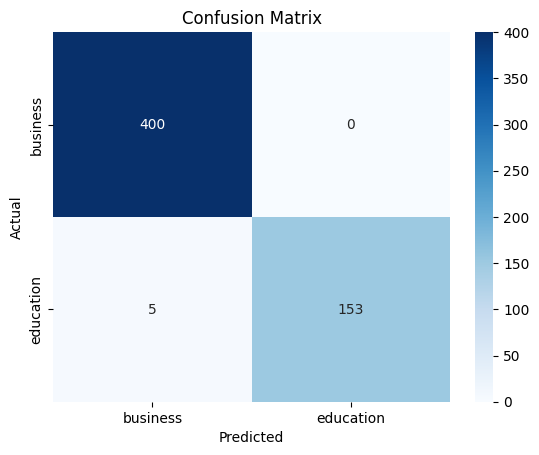

✅ Predictions saved to predictions.csv


In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 10. Export predictions
df_output = df.iloc[y_test.index.to_list()].copy()
df_output['Predicted_Category'] = y_pred
df_output[['headlines', 'Predicted_Category']].to_csv("predictions.csv", index=False)
print("✅ Predictions saved to predictions.csv")